In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame

from dataset.synthetic import SyntheticBanditDatasetWithCluster
from ope.estimator import InversePropensityScore as IPS
from ope.estimator import OFFCEM
from policy.policylearners import PolicyLearnerOverActionSpaces
from policy.policylearners import PolicyLearnerOverClusterSpaces
from policy.policylearners import RegBasedPolicyLearner
from utils.common import visualize_learning_curve

In [2]:
# setting
n_users=50
dim_context=10
n_actions=100
n_cat_per_dim=10
n_cat_dim=5
n_clusters=20
beta=-0.5
reward_noise=1.0
random_state=12345
n_sim=10
val_size=1000
test_size=1000
hidden_layer_size=(30, 30, 30)
max_iter=30

In [3]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    reward_noise=reward_noise,
    random_state=random_state
)
n_clusters = dataset.n_clusters

test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
pi_b_value = (test_data["expected_reward"] * test_data["pi_b"]).sum(1).mean()

curve_df = DataFrame()
for _ in tqdm(range(n_sim)):
    val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
    
    # Reg-based
    reg = RegBasedPolicyLearner(
        dim_context=dim_context, 
        num_actions=n_actions, 
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=0.01,
        ope_estimator=IPS(estimator_name="IPS")
    )
    reg.fit(val_data, test_data)
    reg_ = DataFrame([reg.test_value, ["Reg-based"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # IPS-PG
    ips = PolicyLearnerOverActionSpaces(
        dim_context=dim_context, 
        num_actions=n_actions, 
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=0.01,
        ope_estimator=IPS(estimator_name="IPS")
    )
    ips.fit(val_data, test_data)
    ips_ = DataFrame([ips.test_value, ["IPS-PG"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # DR-PG
    dr = PolicyLearnerOverActionSpaces(
        dim_context=dim_context, 
        num_actions=n_actions, 
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=0.01,
        ope_estimator=IPS(estimator_name="IPS")
    )
    
    q_hat = np.random.normal(val_data["expected_reward"], scale=1.)
    dr.fit(val_data, test_data, q_hat=q_hat)
    dr_ = DataFrame([dr.test_value, ["DR-PG"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # POTEC
    potec = PolicyLearnerOverClusterSpaces(
        dim_context=dim_context, 
        num_actions=n_actions,
        num_clusters=n_clusters,
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=0.01,
        ope_estimator=OFFCEM(estimator_name="OFFCEM")
    )
    
    user_idx, phi_x_a = val_data["user_idx"], val_data["phi_x_a"]
    h_hat = np.random.normal(dataset.h_x_a[user_idx], scale=1.)
    g_hat = np.random.normal(dataset.g_x_c[user_idx], scale=1.)
    f_hat = h_hat + g_hat[np.arange(val_size)[:, None], phi_x_a]
    
    user_idx, phi_x_a = test_data["user_idx"], test_data["phi_x_a"]
    h_hat = np.random.normal(dataset.h_x_a[user_idx], scale=1.)
    g_hat = np.random.normal(dataset.g_x_c[user_idx], scale=1.)
    f_hat_test = h_hat + g_hat[np.arange(test_size)[:, None], phi_x_a]
    
    potec.fit(val_data, test_data, f_hat=f_hat, f_hat_test=f_hat_test)
    potec_ = DataFrame([potec.test_value, ["POTEC"] * max_iter], index=["value", "method"]).T.reset_index()
    potec_offcem_ = DataFrame([potec.test_estimated_value, ["OPL: POTEC, OPE: OFFCEM"] * max_iter], index=["value", "method"]).T.reset_index()
    
    
    curve_df = pd.concat([curve_df, pd.concat([reg_, ips_, dr_, potec_, potec_offcem_])])
curve_df.reset_index(inplace=True) 
curve_df["pi_b_value"] = pi_b_value
curve_df["rel_value"] = curve_df["value"] / pi_b_value

100% 10/10 [02:03<00:00, 12.33s/it]


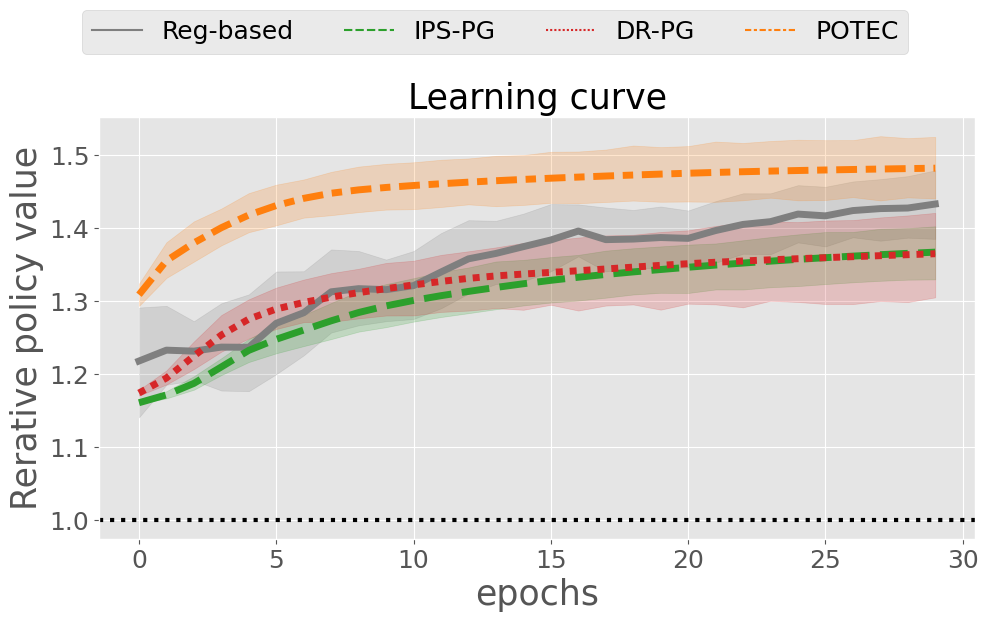

In [4]:
mask = curve_df["method"] != "OPL: POTEC, OPE: OFFCEM"
visualize_learning_curve(curve_df[mask])

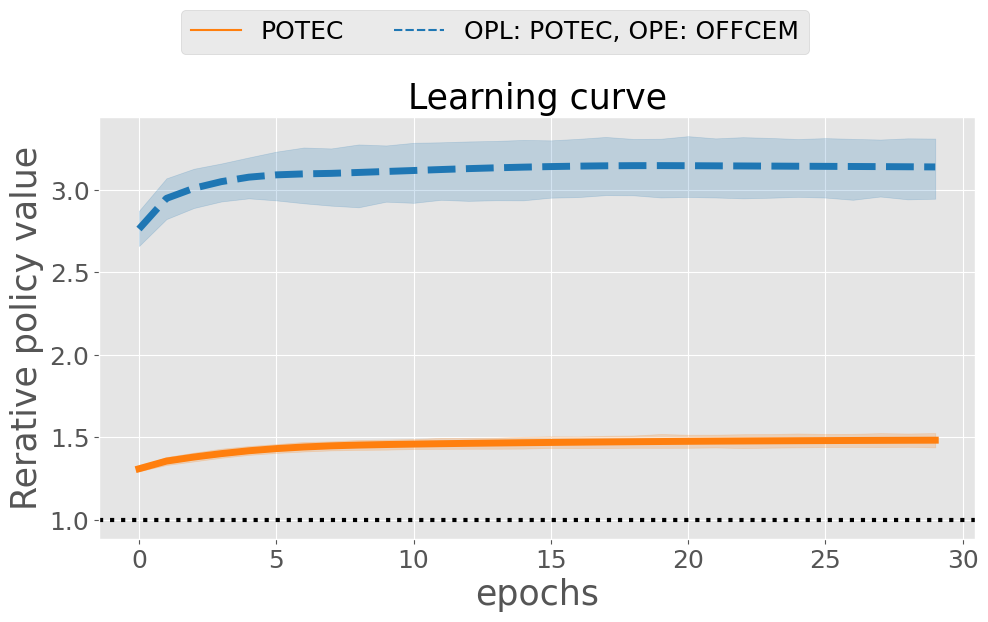

In [5]:
# comparison of true policy value and estimated policy value for each epoch.
# OFFCEM overestimated the true value during optimization of hyperparameters.
mask = (curve_df["method"] == "OPL: POTEC, OPE: OFFCEM") | (curve_df["method"] == "POTEC")
visualize_learning_curve(curve_df[mask])